In [1]:
import sympy as sy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import hylife.utilitis_FEEC.Bspline               as bspline
import hylife.utilitis_FEEC.bsplines              as bsp
import hylife.utilitis_FEEC.derivatives           as der
import hylife.utilitis_FEEC.spline_mappings_polar as splmap
import hylife.utilitis_FEEC.evaluation            as eva
import hylife.utilitis_FEEC.mass_matrices         as mass
import hylife.utilitis_FEEC.projectors_global     as proj
import hylife.utilitis_FEEC.spline_space          as spl

In [2]:
Nel = [20, 12]          # mesh generation on logical domain (radial, angular)
bc  = [False, True]     # boundary conditions
p   = [3, 3]            # spline degrees  

el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors         (discrete mapping)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (discrete mapping)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (discrete mapping)


# polar region
T_pole      = [T[0], np.repeat(T[1], 4)[9:-9]]
p_pole      = [p[0], 2*p[1]]
NbaseN_pole = [NbaseN[0], len(T_pole[1]) - p_pole[1] - 1 - p[1]]

In [4]:
spaces = [spl.spline_space_1d(T, p, bc, p + 1) for T, p, bc in zip(T, p, bc)]

In [13]:
spaces

In [14]:
tensor_space = spl.tensor_spline_space(spaces)

In [27]:
tensor_space.spline_spaces

In [32]:
tensor_space.p[1] = 4

In [33]:
tensor_space.p

[3, 4]

In [34]:
p

[3, 4]

(-1.2063910417926547,
 2.3953300547342717,
 -1.8008605482634632,
 1.8008605482634632)

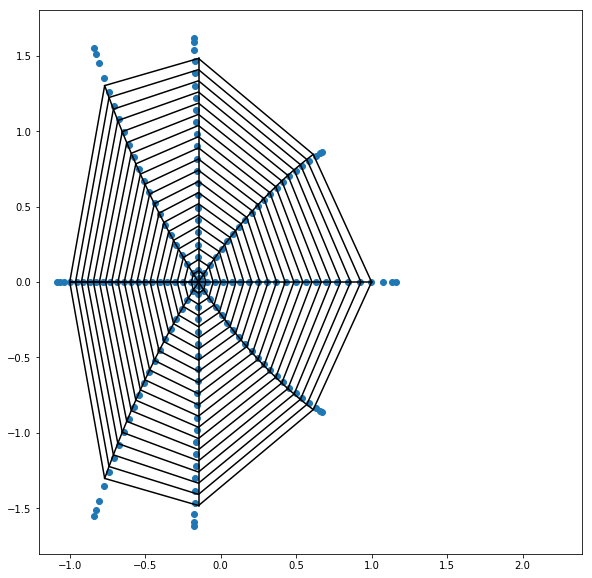

In [3]:
geometry = 'tokamak 2'

spline_map = splmap.discrete_mapping_2d(T, p, bc, geometry)

qplot = [np.linspace(0., 1., Nel[0] + 1), np.linspace(0., 1., Nel[1] + 1)]
xplot, yplot = spline_map.mapping(qplot)
tau, lam = spline_map.barycentric_coordinates(1)


# coordinates of control triangle
Tx = np.array([tau, -tau/2, -tau/2, tau])
Ty = np.array([0., np.sqrt(3)/2*tau, -np.sqrt(3)/2*tau, 0.])

tx = np.array([tau/4, tau/4, -tau/2, tau/4])
ty = np.array([-np.sqrt(3)/4*tau, np.sqrt(3)/4*tau, 0., -np.sqrt(3)/4*tau])

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)


for i in range(len(qplot[0])):
    plt.plot(xplot[i, :], yplot[i, :], 'k')
    
for i in range(len(qplot[1])):
    plt.plot(xplot[:, i], yplot[:, i], 'k')
    
plt.scatter(spline_map.c[0].flatten(), spline_map.c[1].flatten())

#plt.plot(Tx, Ty)
#plt.plot(tx, ty)

plt.axis('square')

In [43]:
qplot = [np.array([0.3]), np.array([0.3])]
#qplot = [np.linspace(0., 1., 500), np.linspace(0., 1., 500)]
print(spline_map.metric_tensor_inverse(qplot, '11'))
#test = spline_map.jacobian_determinant(qplot)

[[0.43925715]]


In [21]:
n_int = 2*p_pole[1] - 1
n_lambda_int = np.copy(NbaseN_pole[1])

In [22]:
x_int = np.zeros((n_lambda_int, n_int), dtype=float)

for i in range(n_lambda_int):
    for j in range(n_int):
        x_int[i, j] = ((T_pole[1][i + 1 + int(j/2)] + T_pole[1][i + 1 + int((j + 1)/2)])/2)%1.

In [16]:
x_int

array([[0.95 , 0.95 , 0.95 , 0.975, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ],
       [0.95 , 0.975, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.025, 0.05 ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.05 ,
        0.05 , 0.05 ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.05 , 0.05 , 0.05 ,
        0.05 , 0.05 ],
       [0.   , 0.   , 0.   , 0.025, 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
        0.05 , 0.05 ],
       [0.   , 0.025, 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
        0.075, 0.1  ],
       [0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.075, 0.1  ,
        0.1  , 0.1  ],
       [0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.075, 0.1  , 0.1  , 0.1  ,
        0.1  , 0.1  ],
       [0.05 , 0.05 , 0.05 , 0.075, 0.1  , 0.1  , 0.1  , 0.1  , 0.1  ,
        0.1  , 0.1  ],
       [0.05 , 0.075, 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  ,
        0.125, 0.15 ],
       [0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1

In [17]:
T_pole[1]

array([-0.05, -0.05, -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.05,  0.05,
        0.05,  0.05,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.15,  0.15,  0.15,
        0.15,  0.2 ,  0.2 ,  0.2 ,  0.2 ,  0.25,  0.25,  0.25,  0.25,
        0.3 ,  0.3 ,  0.3 ,  0.3 ,  0.35,  0.35,  0.35,  0.35,  0.4 ,
        0.4 ,  0.4 ,  0.4 ,  0.45,  0.45,  0.45,  0.45,  0.5 ,  0.5 ,
        0.5 ,  0.5 ,  0.55,  0.55,  0.55,  0.55,  0.6 ,  0.6 ,  0.6 ,
        0.6 ,  0.65,  0.65,  0.65,  0.65,  0.7 ,  0.7 ,  0.7 ,  0.7 ,
        0.75,  0.75,  0.75,  0.75,  0.8 ,  0.8 ,  0.8 ,  0.8 ,  0.85,
        0.85,  0.85,  0.85,  0.9 ,  0.9 ,  0.9 ,  0.9 ,  0.95,  0.95,
        0.95,  0.95,  1.  ,  1.  ,  1.  ,  1.  ,  1.05,  1.05,  1.05])

# 1. Test C1 polar splines

In [8]:
# get extraction operator
E, tau = spline_map.C1_coefficients()

In [9]:
# evaluate tensor basis
qplot = [np.linspace(0., 1., 500), np.linspace(0., 1., 500)]

N     = [sp.sparse.csr_matrix(bsp.collocation_matrix(T, p, qplot, bc)) for T, p, qplot, bc in zip(T, p, qplot, bc)]
N     =  sp.sparse.kron(N[0], N[1])

basis = E.dot(N.T)

(-0.9999800245992065,
 1.0000099860671545,
 -0.9999950053331806,
 0.9999950053331804)

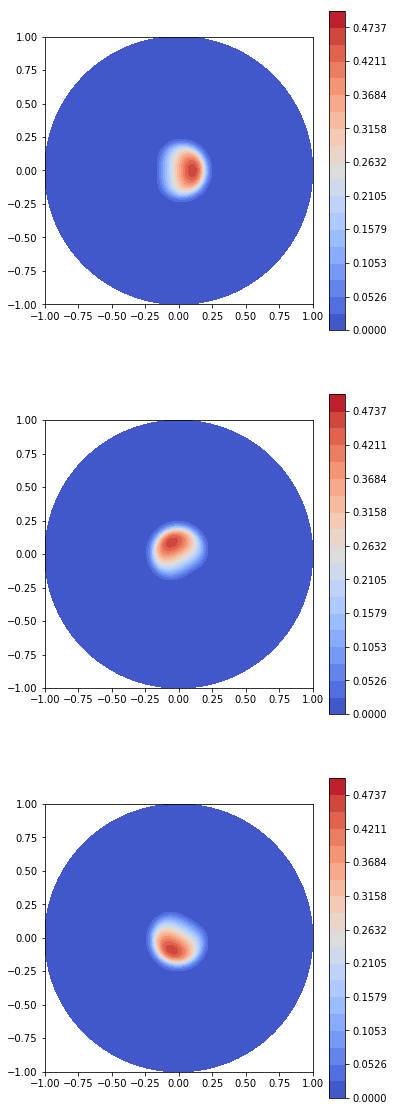

In [10]:
# plot three new basis functions at pole
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(20)

X, Y = spline_map.mapping(qplot)

plt.subplot(3, 1, 1)
plt.contourf(X, Y, basis[0].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 1, 2)
plt.contourf(X, Y, basis[1].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 1, 3)
plt.contourf(X, Y, basis[2].toarray().reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.5, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

In [112]:
# ... coordinates
s, phi = sy.symbols('s, phi')
q      = sy.Matrix([s, phi])

# ... mapping
x0    = 0.
y0    = 0.
kappa = 0.3
delta = 0.2


#F = sy.Matrix([x0 + s*sy.cos(2*sy.pi*phi), y0 + s*sy.sin(2*sy.pi*phi)])
#F = sy.Matrix([x0 + sy.sqrt(s)*sy.cos(2*sy.pi*phi), y0 + sy.sqrt(s)*sy.sin(2*sy.pi*phi)])
F = sy.Matrix([x0 + (1 - kappa)*s*sy.cos(2*sy.pi*phi) - delta*s**2, y0 + (1 + kappa)*s*sy.sin(2*sy.pi*phi)])
# ...

# ... jacobian matrix and its inverse
DF    = sy.simplify(F.jacobian(q))
DFinv = DF.inverse()

# ... metric tensor and its inverse
G    = sy.simplify(DF.transpose()*DF)
Ginv = G.inverse()

#... square root of jacobi determinant
g      = sy.simplify(G.det())
g_sqrt = sy.sqrt(g)

In [113]:
# ... create model with method of manufactured solutions
#phi0     = (1 - s**2)*sy.cos(2*sy.pi*F[0])*sy.sin(2*sy.pi*F[1] + sy.pi/2)
phi0     = (1 - s**2)*sy.cos(2*sy.pi*F[0])*sy.sin(2*sy.pi*F[1])

dphi0    = sy.Matrix([sy.diff(phi0, s), sy.diff(phi0, phi)])
temp     = g_sqrt*Ginv*dphi0

n2       = -(sy.diff(temp[0], s) + sy.diff(temp[1], phi))
hodge_n2 = 1/g_sqrt*n2


phi0     = sy.lambdify(q, phi0)
hodge_n2 = sy.lambdify(q, hodge_n2)

# ... convert mapping functions to callables
xc = sy.lambdify(q, F[0])
yc = sy.lambdify(q, F[1])

G      = [[sy.lambdify(q, G[0, 0])   , sy.lambdify(q, G[0, 1])]   , [sy.lambdify(q, G[1, 0])   , sy.lambdify(q, G[1, 1])]]
Ginv   = [[sy.lambdify(q, Ginv[0, 0]), sy.lambdify(q, Ginv[0, 1])], [sy.lambdify(q, Ginv[1, 0]), sy.lambdify(q, Ginv[1, 1])]]
g      = sy.lambdify(q, g)
g_sqrt = sy.lambdify(q, g_sqrt)

(-0.8999861271636242,
 1.7000009908849716,
 -1.299993559024298,
 1.299993559024298)

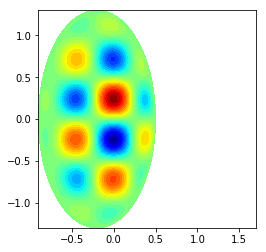

In [114]:
Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

X, Y = xc(Q1plot, Q2plot), yc(Q1plot, Q2plot)

plt.contourf(X, Y, phi0(Q1plot, Q2plot), cmap='jet', levels=np.linspace(-1., 1., 30))
plt.axis('square')

(-0.8999861174007647,
 1.7000009909507172,
 -1.299993554175741,
 1.299993554175741)

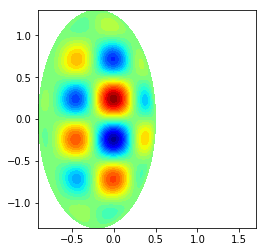

In [115]:
# test L2-projection in V0
M0 = mass.mass_V0_2d(T, p, bc, geometry)
F0 = mass.inner_prod_V0_2d(T, p, bc, geometry, phi0)

result = sp.sparse.linalg.spsolve(E.dot(M0).dot(E.T), E.dot(F0.flatten()))
result = E.T.dot(result)

test = eva.FEM_field_V0_2d(result, qplot, T, p, bc).reshape(len(qplot[0]), len(qplot[1]))

X, Y = spline_map.mapping(qplot)
plt.contourf(X, Y, test, cmap='jet', levels=np.linspace(-1., 1., 30))
plt.axis('square')

/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


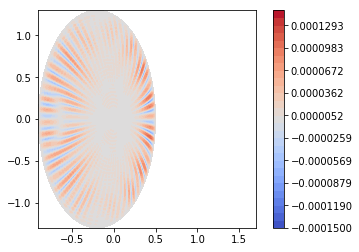

In [122]:
# test Poisson 

# discrete gradient matrix
DER  = der.discrete_derivatives(T, p, bc)
GRAD = DER.GRAD_2d()

# mass matrix in H(curl)
M1 = mass.mass_V1_2d_curl(T, p, bc, geometry)

# right-hand side in H1
RHS = mass.inner_prod_V0_2d(T, p, bc, geometry, hodge_n2)

# C1 smoothness constraint
LHS = E.dot(GRAD.T).dot(M1).dot(GRAD).dot(E.T)
RHS = E.dot(RHS.flatten())

# Dirichlet boundary conditions at outer boundary (last NbaseN[1] entries)
LHS[-NbaseN[1]:, :] = 0.
LHS[:, -NbaseN[1]:] = 0.
LHS[-NbaseN[1]:, -NbaseN[1]:] = np.identity(NbaseN[1])
RHS[-NbaseN[1]:] = 0.

# solve system and pull back on tensor product space
result = E.T.dot(sp.sparse.linalg.spsolve(LHS, RHS))

test = eva.FEM_field_V0_2d(result, qplot, T, p, bc).reshape(len(qplot[0]), len(qplot[1]))

X, Y = spline_map.mapping(qplot)
plt.contourf(X, Y, test - phi0(Q1plot, Q2plot), cmap='coolwarm', levels=np.linspace(-1.5e-4, 1.5e-4, 30))
plt.axis('square')
plt.colorbar()

In [124]:
# L2 error
error = mass.L2_error_V0_2d(result.reshape(NbaseN[0], NbaseN[1]), T, p, bc, geometry, phi0)

In [120]:
error

3.910252727513547e-05

In [56]:
error

2.0318551329795354e-06

In [126]:
# L infinity norm
GREV1, GREV2 = np.meshgrid(spline_map.greville[0], spline_map.greville[1], indexing='ij')

error = np.abs(eva.FEM_field_V0_2d(result, [spline_map.greville[0], spline_map.greville[1]], T, p, bc) - phi0(GREV1, GREV2).flatten()).max()

In [23]:
# test inverse mapping
spline_map.mapping([np.array([-0.5]), np.array([0.15])])

(array([[-0.29376118]]), array([[-0.40432758]]))

# 2. Test C2 polar splines

Text(0.5,1,'Mapping')

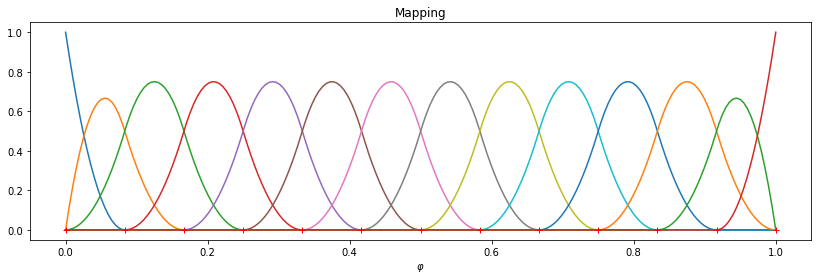

In [39]:
f = plt.figure()
f.set_figwidth(14)


N3 = bspline.Bspline(T[1], p[1])
phiplot = np.linspace(0., 1., 200)

for i in range(N3.N):
    plt.plot(phiplot, N3(phiplot, i))
    
plt.plot(el_b[1], np.zeros(el_b[1].size), 'r+')
plt.xlabel(r'$\varphi$')
plt.title('Mapping')

Text(0.5,1,'Finite elements (N)')

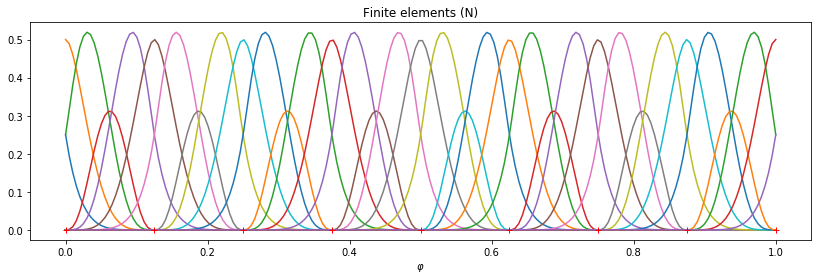

In [4]:
f = plt.figure()
f.set_figwidth(14)


N6 = bspline.Bspline(T_pole[1], p_pole[1])
phiplot = np.linspace(0., 1., 200)

for i in range(N6.N):
    plt.plot(phiplot, N6(phiplot, i))
    
plt.plot(el_b[1], np.zeros(el_b[1].size), 'r+')
    
plt.xlabel(r'$\varphi$')
plt.title('Finite elements (N)')

Text(0.5,1,'Finite elements (D)')

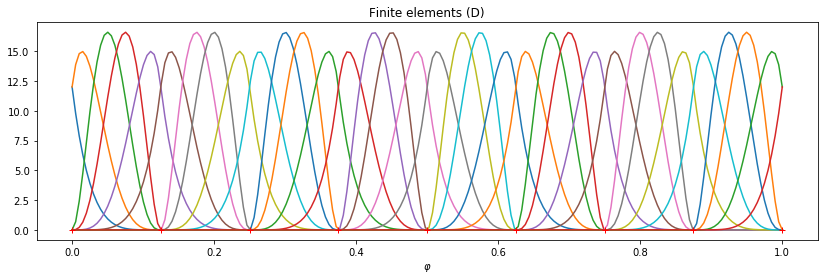

In [5]:
f = plt.figure()
f.set_figwidth(14)


D6 = bspline.Bspline(T_pole[1][1:-1], p_pole[1] - 1)
phiplot = np.linspace(0., 1., 200)

for i in range(D6.N):
    plt.plot(phiplot, D6(phiplot, i)*p_pole[1]/(T_pole[1][1:-1][i + p_pole[1]] - T_pole[1][1:-1][i]))
    
plt.plot(el_b[1], np.zeros(el_b[1].size), 'r+')
    
plt.xlabel(r'$\varphi$')
plt.title('Finite elements (D)')

In [ ]:
test = bsp.collocation_matrix

In [53]:
N6 = bspline.Bspline(T_pole[1], p_pole[1])

In [61]:
N6(0.1, 2, 1)

array(-2.30016)

In [62]:
slice(0, 56)

slice(0, 56, None)

In [65]:
# local interpolation points for spline 1
xint1 = np.linspace(0., el_b[1][1], 7)

# local collocation matrix
lhs_loc1 = np.zeros((7, 7), dtype=float)

for i in range(7):
    span = bsp.find_span(T_pole[1], p_pole[1], xint1[i])
    
    if span == 10:
        span = 6
    
    lhs_loc1[i] = bsp.basis_funs(T_pole[1], p_pole[1], xint1[i], span)
    
# solve local linear system
coeff1 = np.linalg.solve(lhs_loc1, np.array([0., 0., 0., 1., 0., 0., 0.]))

In [176]:
import hylife.utilitis_FEEC.projectors_global as pr_glob

In [189]:
test = pr_glob.histopolation_matrix_1d(T[1], p[1], bsp.greville(T[1], p[1], True), True)

In [190]:
test

array([[0.16666667, 0.66666667, 0.16666667, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.16666667, 0.66666667, 0.16666667, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.16666667, 0.66666667, 0.16666667,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.16666667, 0.66666667,
        0.16666667, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.16666667,
        0.66666667, 0.16666667, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.66666667, 0.16666667],
       [0.16666667, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.16666667, 0.66666667],
       [0.66666667, 0.16666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16666667]])

In [191]:
grev = bsp.greville(T[1], p[1], True)

In [192]:
test = bsp.collocation_matrix(T[1], p[1], grev[:2], True)

In [196]:
(test[0, 0] - test[1, 0]) + (test[0, 1] - test[1, 1]) + (test[0, 2] - test[1, 2])

0.16666666666666663

In [170]:
# local interpolation points for spline 2
xint2 = np.linspace(0., el_b[1][2], 11)

# local collocation matrix
lhs_loc2 = np.zeros((11, 11), dtype=float)

for i in range(11):
    span = bsp.find_span(T_pole[1], p_pole[1], xint2[i])
    
    if span == 14:
        span = 10
    
    if i < 5:
        lhs_loc2[i, :7] = bsp.basis_funs(T_pole[1], p_pole[1], xint2[i], span)
    elif i >= 5:
        lhs_loc2[i, -7:] = bsp.basis_funs(T_pole[1], p_pole[1], xint2[i], span)
    
# solve local linear system
coeff11 = np.linalg.solve(lhs_loc2, np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))
coeff12 = np.linalg.solve(lhs_loc2, np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))
coeff13 = np.linalg.solve(lhs_loc2, np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))
coeff14 = np.linalg.solve(lhs_loc2, np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))
coeff15 = np.linalg.solve(lhs_loc2, np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

#co = [coeff11, coeff12, coeff13, coeff14]
co = [coeff12, coeff13, coeff14, coeff15]

In [171]:
xint = np.zeros((NbaseN_pole[1], 11))
coeff = np.zeros((NbaseN_pole[1], 11))

for i in range(NbaseN_pole[1]):
    ii = int(i/4)
    
    if ii == 0:
        xint[i, :6] = np.linspace(el_b[1][-2], 1, 6)%1
        xint[i, 6:] = np.linspace(el_b[1][0], el_b[1][1], 6)[1:]
        
    else:
        xint[i] = np.linspace(el_b[1][ii - 1], el_b[1][ii + 1], 11)
        
    coeff[i] = co[i%4]

In [172]:
# perform interpolation
fun = lambda x : np.sin(np.sin(2*np.pi*x))

lambdas = np.zeros(NbaseN_pole[1])
for i in range(NbaseN_pole[1]):
    for j in range(11):
        lambdas[i] += coeff[i, j]*fun(xint[i, j])

In [173]:
xplot = np.linspace(0., 1., 100)
N = np.zeros((xplot.size, NbaseN_pole[1]), dtype=float)

for i in range(xplot.size):
    span = bsp.find_span(T_pole[1], p_pole[1], xplot[i])
    
    loc = bsp.basis_funs(T_pole[1], p_pole[1], xplot[i], span)
    
    for il in range(p_pole[1] + 1):
        
        j = (span - il)%NbaseN_pole[1]
        N[i, j] = loc[p_pole[1]-il]

In [174]:
test = N.dot(lambdas)

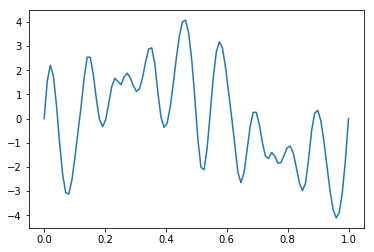

In [175]:
plt.plot(xplot, test)

We need the following transformations betwenn the mapping spline space and the one for constructing the finite element basis

\begin{align}
&\sum_ia_i^3\int_0^1N^3_i(\varphi)N^6_j(\varphi)\mathrm{d}\varphi=\sum_ia_i^6\int_0^1N^6_i(\varphi)N^6_j(\varphi)\mathrm{d}\varphi \qquad \forall j\\
&\sum_{ij}a_i^3a_j^3\int_0^1 N_i^3(\varphi)N_j^3(\varphi)N_k^6(\varphi)\mathrm{d}\varphi=\sum_ia_i^6\int_0^1N^6_i(\varphi)N^6_k(\varphi)\mathrm{d}\varphi \qquad \forall k
\end{align}

In [51]:
# get extraction operator
E, tau = spline_map.C2_coefficients()

In [52]:
E.shape

(446, 560)

In [53]:
NbaseN_pole

[14, 40]

In [54]:
# plot 6 new basis functions on physical domain
qplot = np.linspace(0., 1., 500), np.linspace(0., 1., 500)

Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

# evaluate tensor basis
N1 = np.zeros((len(qplot[0]), NbaseN_pole[0]))
N2 = np.zeros((len(qplot[1]), NbaseN_pole[1]))

for i in range(len(qplot[1])):
    
    span1  = bsp.find_span(T_pole[0], p_pole[0], qplot[0][i])
    span2  = bsp.find_span(T_pole[1], p_pole[1], qplot[1][i])
    
    basis1 = bsp.basis_funs(T_pole[0], p_pole[0], qplot[0][i], span1)
    basis2 = bsp.basis_funs(T_pole[1], p_pole[1], qplot[1][i], span2)
    
    
    for jl in range(p_pole[0] + 1):
        
        j = (span1 - jl)%NbaseN_pole[0]
        
        N1[i, j] = basis1[p_pole[0] - jl]
        
    for jl in range(p_pole[1] + 1):
        
        j = (span2 - jl)%NbaseN_pole[1]
        
        N2[i, j] = basis2[p_pole[1] - jl]
        
N = np.kron(N1, N2)

basis = E.dot(N.T)

(-0.9999795344504673,
 0.9999999999999999,
 -0.9995478735730813,
 1.000431660877386)

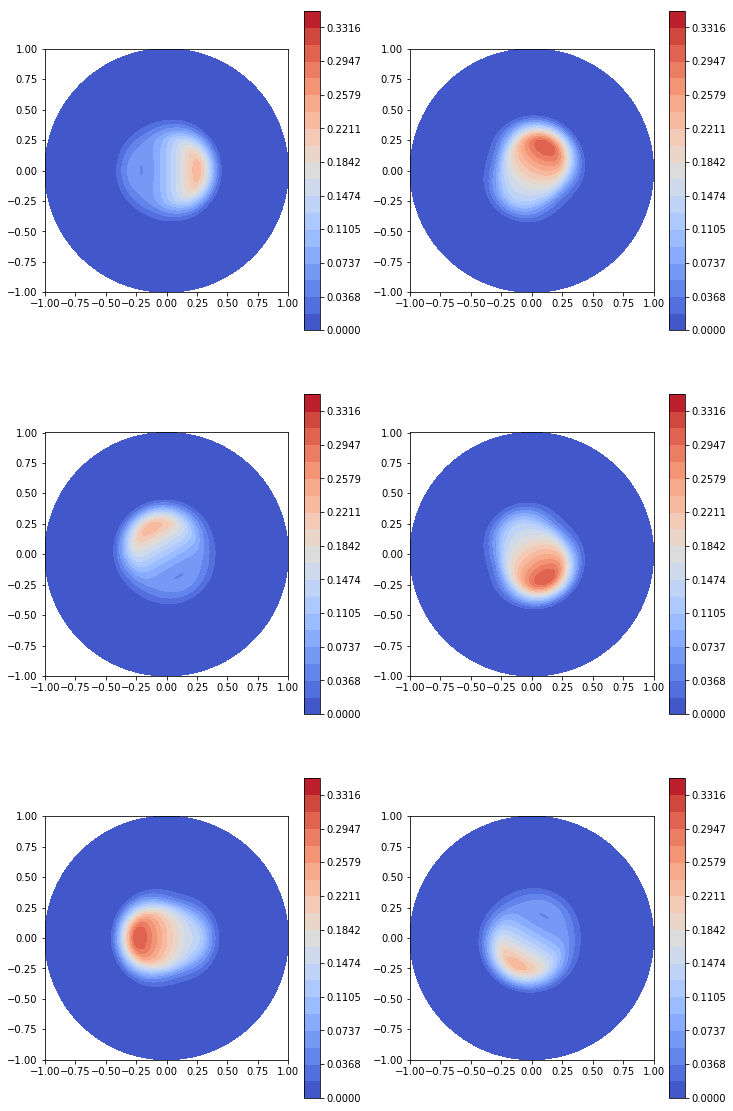

In [59]:
# plot six new basis functions at pole
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(20)

X, Y = spline_map.mapping(qplot)

plt.subplot(3, 2, 1)
plt.contourf(X, Y, basis[0].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 2, 2)
plt.contourf(X, Y, basis[1].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 2, 3)
plt.contourf(X, Y, basis[2].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 2, 4)
plt.contourf(X, Y, basis[3].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 2, 5)
plt.contourf(X, Y, basis[4].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

plt.subplot(3, 2, 6)
plt.contourf(X, Y, basis[5].reshape(500, 500), cmap='coolwarm', levels=np.linspace(0., 0.35, 20))
#plt.xlim((-0.2, 0.2))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

In [84]:
# plot gradient of 6 new basis functions on physical domain
qplot = np.linspace(1e-10, 1., 100), np.linspace(0., 1., 100)

Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

# evaluate tensor basis
D1 = np.zeros((len(qplot[0]), NbaseN_pole[0]))
N2 = np.zeros((len(qplot[1]), NbaseN_pole[1]))

N1 = np.zeros((len(qplot[0]), NbaseN_pole[0]))
D2 = np.zeros((len(qplot[1]), NbaseN_pole[1]))

for i in range(len(qplot[1])):
    
    span1  = bsp.find_span(T_pole[0], p_pole[0], qplot[0][i])
    span2  = bsp.find_span(T_pole[1], p_pole[1], qplot[1][i])
    
    basisN1 = bsp.basis_funs(T_pole[0], p_pole[0], qplot[0][i], span1)
    basisN2 = bsp.basis_funs(T_pole[1], p_pole[1], qplot[1][i], span2)
    
    basisD1 = bsp.basis_funs_1st_der(T_pole[0], p_pole[0], qplot[0][i], span1)
    basisD2 = bsp.basis_funs_1st_der(T_pole[1], p_pole[1], qplot[1][i], span2)
    
    
    for jl in range(p_pole[0] + 1):
        
        j = (span1 - jl)%NbaseN_pole[0]
        
        N1[i, j] = basisN1[p_pole[0] - jl]
        D1[i, j] = basisD1[p_pole[0] - jl]
        
    for jl in range(p_pole[1] + 1):
        
        j = (span2 - jl)%NbaseN_pole[1]
        
        N2[i, j] = basisN2[p_pole[1] - jl]
        D2[i, j] = basisD2[p_pole[1] - jl]
        
dN_dr = np.kron(D1, N2)
dN_dp = np.kron(N1, D2)

In [85]:
basis_dr = E.dot(dN_dr.T)
basis_dp = E.dot(dN_dp.T)

basis_dr0 = basis_dr[0].reshape(100, 100)
basis_dr1 = basis_dr[1].reshape(100, 100)
basis_dr2 = basis_dr[2].reshape(100, 100)
basis_dr3 = basis_dr[3].reshape(100, 100)
basis_dr4 = basis_dr[4].reshape(100, 100)
basis_dr5 = basis_dr[5].reshape(100, 100)

basis_dp0 = basis_dp[0].reshape(100, 100)
basis_dp1 = basis_dp[1].reshape(100, 100)
basis_dp2 = basis_dp[2].reshape(100, 100)
basis_dp3 = basis_dp[3].reshape(100, 100)
basis_dp4 = basis_dp[4].reshape(100, 100)
basis_dp5 = basis_dp[5].reshape(100, 100)

In [86]:
# evaluate inverse jacobian
DF_inv_00 = spline_map.jacobian_inverse([qplot[0], qplot[1]], '00')
DF_inv_01 = spline_map.jacobian_inverse([qplot[0], qplot[1]], '01')
DF_inv_10 = spline_map.jacobian_inverse([qplot[0], qplot[1]], '10')
DF_inv_11 = spline_map.jacobian_inverse([qplot[0], qplot[1]], '11')

(-0.999481399850961, 1.0, -0.9994290404120797, 1.0000523594388815)

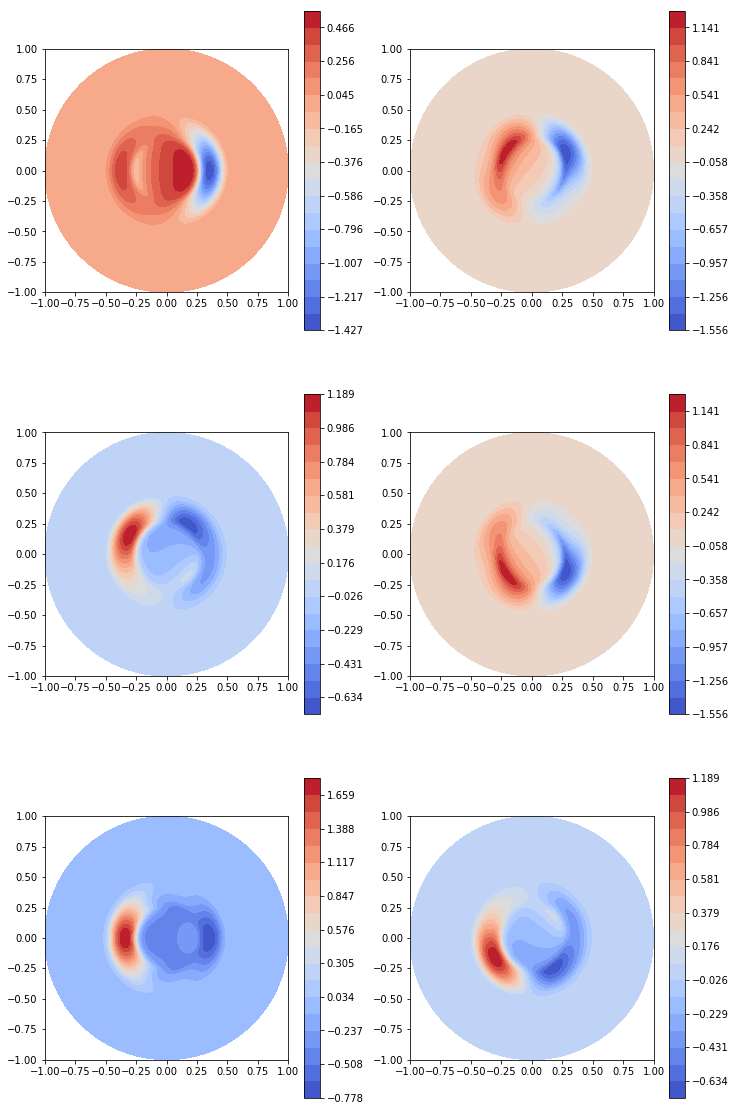

In [89]:
# plot grad_x of six new basis functions at pole
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(20)

X, Y = spline_map.mapping(qplot)

plt.subplot(3, 2, 1)
dN_dx_0 = DF_inv_00*basis_dr0 + DF_inv_10*basis_dp0
plt.contourf(X, Y, dN_dx_0, cmap='coolwarm', levels=np.linspace(dN_dx_0.min(), dN_dx_0.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 2)
dN_dx_1 = DF_inv_00*basis_dr1 + DF_inv_10*basis_dp1
plt.contourf(X, Y, dN_dx_1, cmap='coolwarm', levels=np.linspace(dN_dx_1.min(), dN_dx_1.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 3)
dN_dx_2 = DF_inv_00*basis_dr2 + DF_inv_10*basis_dp2
plt.contourf(X, Y, dN_dx_2, cmap='coolwarm', levels=np.linspace(dN_dx_2.min(), dN_dx_2.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 4)
dN_dx_3 = DF_inv_00*basis_dr3 + DF_inv_10*basis_dp3
plt.contourf(X, Y, dN_dx_3, cmap='coolwarm', levels=np.linspace(dN_dx_3.min(), dN_dx_3.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 5)
dN_dx_4 = DF_inv_00*basis_dr4 + DF_inv_10*basis_dp4
plt.contourf(X, Y, dN_dx_4, cmap='coolwarm', levels=np.linspace(dN_dx_4.min(), dN_dx_4.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 6)
dN_dx_5 = DF_inv_00*basis_dr5 + DF_inv_10*basis_dp5
plt.contourf(X, Y, dN_dx_5, cmap='coolwarm', levels=np.linspace(dN_dx_5.min(), dN_dx_5.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

(-0.999481399850961, 1.0, -0.9994290404120797, 1.0000523594388815)

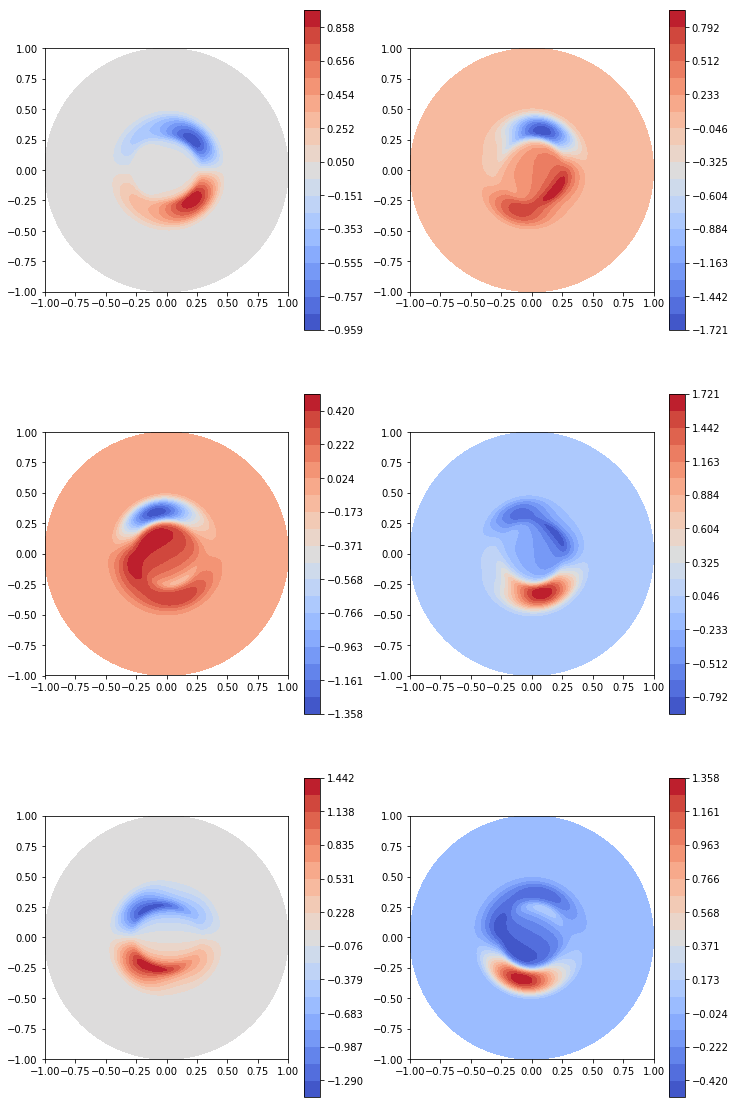

In [97]:
# plot grad_y of six new basis functions at pole
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(20)

X, Y = spline_map.mapping(qplot)

plt.subplot(3, 2, 1)
dN_dy_0 = DF_inv_01*basis_dr0 + DF_inv_11*basis_dp0
plt.contourf(X, Y, dN_dy_0, cmap='coolwarm', levels=np.linspace(dN_dy_0.min(), dN_dy_0.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 2)
dN_dy_1 = DF_inv_01*basis_dr1 + DF_inv_11*basis_dp1
plt.contourf(X, Y, dN_dy_1, cmap='coolwarm', levels=np.linspace(dN_dy_1.min(), dN_dy_1.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 3)
dN_dy_2 = DF_inv_01*basis_dr2 + DF_inv_11*basis_dp2
plt.contourf(X, Y, dN_dy_2, cmap='coolwarm', levels=np.linspace(dN_dy_2.min(), dN_dy_2.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 4)
dN_dy_3 = DF_inv_01*basis_dr3 + DF_inv_11*basis_dp3
plt.contourf(X, Y, dN_dy_3, cmap='coolwarm', levels=np.linspace(dN_dy_3.min(), dN_dy_3.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 5)
dN_dy_4 = DF_inv_01*basis_dr4 + DF_inv_11*basis_dp4
plt.contourf(X, Y, dN_dy_4, cmap='coolwarm', levels=np.linspace(dN_dy_4.min(), dN_dy_4.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')


plt.subplot(3, 2, 6)
dN_dy_5 = DF_inv_01*basis_dr5 + DF_inv_11*basis_dp5
plt.contourf(X, Y, dN_dy_5, cmap='coolwarm', levels=np.linspace(dN_dy_5.min(), dN_dy_5.max(), 20))
#plt.xlim((-0.3, 0.3))
#plt.ylim((-0.2, 0.2))
plt.colorbar()
plt.axis('square')

In [119]:
# plot mixed derivative of 6 new basis functions on physical domain
qplot = np.linspace(1e-10, 1., 100), np.linspace(0., 1., 100)

Q1plot, Q2plot = np.meshgrid(qplot[0], qplot[1], indexing='ij')

# evaluate tensor basis
D1 = np.zeros((len(qplot[0]), NbaseN_pole[0]))
D2 = np.zeros((len(qplot[1]), NbaseN_pole[1]))

for i in range(len(qplot[1])):
    
    span1  = bsp.find_span(T_pole[0], p_pole[0], qplot[0][i])
    span2  = bsp.find_span(T_pole[1], p_pole[1], qplot[1][i])
    
    basisD1 = bsp.basis_funs_1st_der(T_pole[0], p_pole[0], qplot[0][i], span1)
    basisD2 = bsp.basis_funs_1st_der(T_pole[1], p_pole[1], qplot[1][i], span2)
    
    
    for jl in range(p_pole[0] + 1):
        
        j = (span1 - jl)%NbaseN_pole[0]
        
        D1[i, j] = basisD1[p_pole[0] - jl]
        
    for jl in range(p_pole[1] + 1):
        
        j = (span2 - jl)%NbaseN_pole[1]
        
        D2[i, j] = basisD2[p_pole[1] - jl]
        
dN_drdp = np.kron(D1, D2)
basis = E.dot(dN_drdp.T)